In [1]:
import itertools
import json
from pprint import pprint
from typing import List

import clip  # type: ignore
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr, pearsonr

from datasets import AttributeDataset, ImageDataset, TextDataset, create_dataloader
from models import Linear
from trainer import run_one_epoch
from utils import computing_subgroup_metrics, subgrouping
from matplotlib import pyplot as plt
from utils import openai_imagenet_template, openai_imagenet_classes
from collections import defaultdict


CLIP_MODEL = "ViT-B/32"
LINEAR_MODEL = "waterbird_linear_model.pt"
N_CLASS = 2
clip_model, transform = clip.load(name=CLIP_MODEL, device="cuda")
clip_model = clip_model.float()
model = Linear(clip_model.visual.output_dim, N_CLASS).cuda()
state_dict = torch.load(LINEAR_MODEL)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Slice Analysis

## [Preparation] Ground-truth image dataset and text cross-product performance

In [2]:
image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/Waterbird/processed_attribute_dataset/attributes.jsonl"
    )
]


def filter_fn(x):
    return x["attributes"]["split"] == "val"


image_data = [x for x in image_data if filter_fn(x)]


def label_fn(x):
    return x["attributes"]["waterbird"]


for item in image_data:
    item["label"] = label_fn(item)

image_dataset = ImageDataset(data=image_data)
image_dataloader = create_dataloader(
    dataset=image_dataset, modality="image", transform=transform
)
image_metrics = run_one_epoch(
    dataloader=image_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

# Dataset attributes
attributes = {
    "place": set([x["attributes"]["place"] for x in image_data]),
    "species": set([x["attributes"]["species"] for x in image_data]),
}
attributes_combinations = [
    dict(zip(attributes, x)) for x in itertools.product(*attributes.values())
]
species_to_label = {
    x["attributes"]["species"]: x["attributes"]["waterbird"] for x in image_data
}
places_to_label = {
    x["attributes"]["place"]: x["attributes"]["waterplace"] for x in image_data
}

################################ Raw ################################
# text_data = [
#     {
#         "text": f"{x['species']}, {x['place']}.",
#         "label": species_to_label[x["species"]],
#         "attributes": {
#             "waterbird": species_to_label[x["species"]],
#             "waterplace": places_to_label[x["place"]],
#             "species": x["species"],
#             "place": x["place"],
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Engineering ################################
# text_data = [
#     {
#         "text": f"a photo of a {x['species']} in the {x['place']}.",
#         "label": species_to_label[x["species"]],
#         "attributes": {
#             "waterbird": species_to_label[x["species"]],
#             "waterplace": places_to_label[x["place"]],
#             "species": x["species"],
#             "place": x["place"],
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Ensemble ################################
text_data = [
    {
        "text": prompt(f"{x['species']} in the {x['place']}"),
        "label": species_to_label[x["species"]],
        "attributes": {
            "waterbird": species_to_label[x["species"]],
            "waterplace": places_to_label[x["place"]],
            "species": x["species"],
            "place": x["place"],
        },
    }
    for x in attributes_combinations
    for prompt in openai_imagenet_template
]

# TODO: select one from above

text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:54<00:00, 36.43it/s]


## Larger slice discovery

In [3]:
fields = ["waterbird", "waterplace"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1]))
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1]))
print()

[((('waterbird', 1), ('waterplace', 0)), 0.49624060150375937),
 ((('waterbird', 0), ('waterplace', 1)), 0.6459227467811158),
 ((('waterbird', 1), ('waterplace', 1)), 0.9473684210526315),
 ((('waterbird', 0), ('waterplace', 0)), 0.9957173447537473)]

[((('waterbird', 1), ('waterplace', 0)), 0.38967391304347826),
 ((('waterbird', 0), ('waterplace', 1)), 0.7395292207792208),
 ((('waterbird', 1), ('waterplace', 1)), 0.9601902173913044),
 ((('waterbird', 0), ('waterplace', 0)), 1.0)]



## Atomic slice correlation

In [4]:
def compute_correlation(data1_list: List, data2_list: List) -> None:
    assert len(data1_list) == len(data2_list)
    data1 = np.array(data1_list)
    data2 = np.array(data2_list)
    spearmanr_corr, spearmanr_pval = spearmanr(data1, data2)
    pearsonr_corr, pearsonr_pval = pearsonr(data1, data2)
    print(f"Spearman correlation: {spearmanr_corr:.4f} (p-value: {spearmanr_pval:.4f})")
    print(f"Pearson correlation: {pearsonr_corr:.4f} (p-value: {pearsonr_pval:.4f})")
    plt.figure()
    plt.scatter(data1, data2, alpha=0.3, s=10)
    plt.show()

[((('species', 'American Crow'), ('place', 'lake natural')), 0.0),
 ((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'American Redstart'), ('place', 'ocean')), 0.0)]

[((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'Baltimore Oriole'), ('place', 'ocean')), 0.0),
 ((('species', 'Belted Kingfisher'), ('place', 'lake natural')), 0.0)]

[((('species', 'Western Wood Pewee'), ('place', 'bamboo forest')),
  0.0031716938727186063),
 ((('species', 'Western Wood Pewee'), ('place', 'forest broadleaf')),
  0.0032063519895018542),
 ((('species', 'Eastern Towhee'), ('place', 'bamboo forest')),
  0.010085816623177379)]

Spearman correlation: 0.6393 (p-value: 0.0000)
Pearson correlation: 0.5838 (p-value: 0.0000)


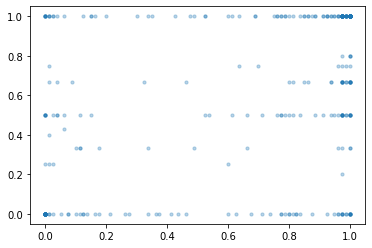

Spearman correlation: 0.6262 (p-value: 0.0000)
Pearson correlation: 0.6486 (p-value: 0.0000)


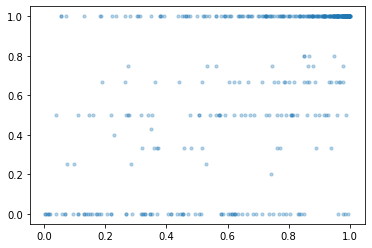

In [5]:
fields = ["species", "place"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (("species", x["attributes"]["species"]), ("place", x["attributes"]["place"]))
    value = text_probs[i][x["attributes"]["waterbird"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [text_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)
compute_correlation(
    [text_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)

## Image Correlation Analysis

Epoch -1, Eval True: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.37it/s]


[((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'American Redstart'), ('place', 'ocean')), 0.0),
 ((('species', 'Anna Hummingbird'), ('place', 'ocean')), 0.0)]

[((('species', 'Parakeet Auklet'), ('place', 'forest broadleaf')),
  0.0008562970906496048),
 ((('species', 'Frigatebird'), ('place', 'forest broadleaf')),
  0.001073575229384005),
 ((('species', 'Scissor tailed Flycatcher'), ('place', 'ocean')),
  0.0012265233090147376)]

Spearman correlation: 0.4611 (p-value: 0.0000)
Pearson correlation: 0.4559 (p-value: 0.0000)


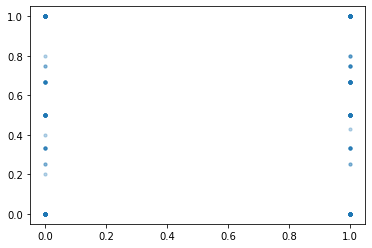

Spearman correlation: 0.5448 (p-value: 0.0000)
Pearson correlation: 0.5307 (p-value: 0.0000)


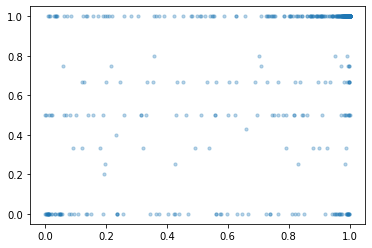

In [6]:
fields = ["species", "place"]

image_generated_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/GeneratedWaterBird/waterbird_text_data_generated_images_n=20.jsonl"
    )
]


def filter_fn(x):
    return True


image_generated_data = [x for x in image_generated_data if filter_fn(x)]


def label_fn(x):
    return x["attributes"]["waterbird"]


for item in image_generated_data:
    item["label"] = label_fn(item)

image_generated_dataset = ImageDataset(data=image_generated_data)
image_generated_dataloader = create_dataloader(
    dataset=image_generated_dataset, modality="image", transform=transform
)
image_generated_metrics = run_one_epoch(
    dataloader=image_generated_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
image_generated_preds, image_generated_labels = (
    image_generated_metrics["preds"],
    image_generated_metrics["labels"],
)
image_generated_subgroups = subgrouping(image_generated_data, fields)
image_generated_subgroup_metrics = computing_subgroup_metrics(
    image_generated_preds, image_generated_labels, image_generated_subgroups
)
pprint(sorted(image_generated_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

image_generated_logits = image_generated_metrics["logits"]
image_generated_probs = (
    torch.softmax(torch.tensor(image_generated_logits), dim=1).numpy().tolist()
)
image_generated_subgroup_probs = defaultdict(list)
for i, x in enumerate(image_generated_data):
    key = (("species", x["attributes"]["species"]), ("place", x["attributes"]["place"]))
    value = image_generated_probs[i][x["attributes"]["waterbird"]]
    image_generated_subgroup_probs[key].append(value)
image_generated_subgroup_probs = {
    k: float(np.mean(v)) for k, v in image_generated_subgroup_probs.items()
}
pprint(sorted(image_generated_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [image_generated_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Accuracy-Accuracy Correlation
compute_correlation(
    [image_generated_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Prob-Accuracy Correlation

# Attribute-based Interpretation

In [7]:
image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/Waterbird/processed_attribute_dataset/attributes.jsonl"
    )
]


def filter_fn(x):
    return x["attributes"]["split"] == "val"


image_data = [x for x in image_data if filter_fn(x)]

attributes = {
    "place": set([x["attributes"]["place"] for x in image_data]),
    "species": set([x["attributes"]["species"] for x in image_data]),
}

## Direct influence

In [8]:
attribute_list = list(attributes["place"])

attribute_embeddings = F.normalize(
    clip_model.encode_text(clip.tokenize(attribute_list).cuda())
)
probs = torch.softmax(model(attribute_embeddings), dim=1)

attribute_scores = {
    attribute_list[i]: float(probs[i, 1]) for i in range(len(attribute_list))
}

print("If we care about waterbird (label = 1), the most similar attributes are:")
print(sorted(attribute_scores.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about waterbird (label = 1), the most similar attributes are:
[('ocean', 0.5517702102661133), ('lake natural', 0.5469737648963928), ('forest broadleaf', 0.3656281530857086), ('bamboo forest', 0.3377529978752136)]


## Aggregated Influence: Shapley Value s(a) = E_{S subset {F \ a}} [f(S, a) - f(S)]

In [9]:
place_list = list(attributes["place"])
species_list = list(attributes["species"])

attribute_shapley = {}
print(
    "If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):"
)
for place in place_list:
    prompts = [f"a photo of a {species}." for species in species_list] + [
        f"a photo of a {species} in the {place}." for species in species_list
    ]
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(species_list) :, 1] - probs[: len(species_list), 1]).mean()
    attribute_shapley[place] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):
[('ocean', tensor(0.1020)),
 ('lake natural', tensor(0.0381)),
 ('forest broadleaf', tensor(-0.0877)),
 ('bamboo forest', tensor(-0.1029))]


In [10]:
place_list = list(attributes["place"])
species_list = list(attributes["species"])

attribute_shapley = {}
print(
    "If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):"
)
for species in species_list:
    prompts = [f"a photo of the {place}." for place in place_list] + [
        f"a photo of a {species} in the {place}." for place in place_list
    ]
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(place_list) :, 1] - probs[: len(place_list), 1]).mean()
    attribute_shapley[species] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):
[('Glaucous winged Gull', tensor(0.1992)),
 ('Sooty Albatross', tensor(0.1895)),
 ('Caspian Tern', tensor(0.1849)),
 ('Black footed Albatross', tensor(0.1793)),
 ('California Gull', tensor(0.1644)),
 ('Laysan Albatross', tensor(0.1617)),
 ('Ring billed Gull', tensor(0.1616)),
 ('Slaty backed Gull', tensor(0.1560)),
 ('Western Grebe', tensor(0.1548)),
 ('Herring Gull', tensor(0.1537))]
